_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Sarah Strauss, Cornelius Schröder

Summer term 2020

Due date: 2019-05-05, 9am

Student names: Shanqian Ma: {1,2}, Weiyi Xiao: {3,4}

# Exercise sheet 2

If needed, download the data files ```nda_ex_1_*.npy``` from ILIAS and save it in the subfolder ```../data/```. Use a subset of the data for testing and debugging. But be careful not to make it too small, since the algorithm may fail to detect small clusters in this case. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import signal
from sklearn.cluster import KMeans
import scipy as sp
from scipy.io import loadmat
import copy
from scipy import linalg
sns.set_style('whitegrid')
%matplotlib inline


In [2]:
np.random.seed(1)

## Load data

In [3]:
# replace by path to your solutions
b = np.load('data//nda_ex_1_features.npy')
s = np.load('data//nda_ex_1_spiketimes.npy')
w = np.load('data//nda_ex_1_waveforms.npy')

## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

*Grading: 1 pts*


In [4]:
def sampleData(N, m, S, p):
#    Generate N samples from a Mixture of Gaussian distribution with
#    means m, covariances S and priors p. The function returns the sampled
#    datapoints x as well as an indicator for the cluster the point 
#    originated from. The number of samples is rounded to the nearest integer.
#
#    m     #components x #dim
#    S     #dim x #dim x #components
#    p     #components
#
#    x     N x #dim
#    ind   N 

    # fill in your code here
    np.random.seed(seed=1)
    data_s=[[],[],[]]
    cluster_ids_s=[[],[],[]]
    for i in range(3):
        data_s[i]=np.random.multivariate_normal(mean=m[i], cov=S[:,:,i], size=int(N*p[i]))
        cluster_ids_s[i]=i*np.ones(int(N*p[i]))
        
    x=np.concatenate((data_s[0], data_s[1], data_s[2]), axis=0)
    ind=np.concatenate((cluster_ids_s[0], cluster_ids_s[1], cluster_ids_s[2]), axis=0)
    
    return (x,ind)    


Specify parameters of Gaussians and run function

In [5]:
N = 1000
m = np.array([[0, 0], [5, 1], [0, 4]])
S1 = np.array([[1, 0], [0, 1]])
S2 = np.array([[2, 1], [1, 2]])
S3 = np.array([[1, -.5], [-.5, 1]])
S = np.concatenate((S1[:,:,np.newaxis],
                    S2[:,:,np.newaxis],
                    S3[:,:,np.newaxis]), axis=2)
p = np.array([.3, .5, .2])

x, ind = sampleData(N, m, S, p)


Plot the toy dataset

(-4, 10)

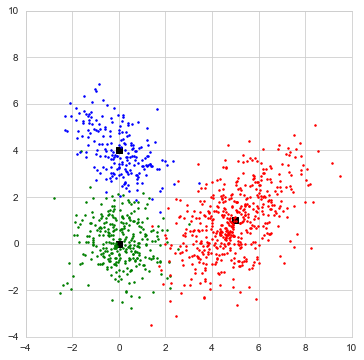

In [6]:
plt.figure(figsize=(6, 6))

ax = plt.subplot(1,1,1, aspect='equal')
plt.plot(x[ind==0,0],x[ind==0,1],'.g', markersize=3) 
plt.plot(x[ind==1,0],x[ind==1,1],'.r', markersize=3) 
plt.plot(x[ind==2,0],x[ind==2,1],'.b', markersize=3)
plt.scatter(m[:,0], m[:,1], s = 30, c = 'k', marker = 's')

plt.xlim((-4,10))
plt.ylim((-4,10))


## Task 2: Implement a Gaussian mixture model

**For students who have not done ML 1 in the winter term:** Implement the EM algorithm to fit a Gaussian mixture model in `mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy. 

**For students who have done ML 1 in the winter term:** You already implemented a Gaussian mixture model in ML 1. Re-use your code from back then here and adapt to the function template here. Make your code more robust by optionally replacing the Gaussian distributions with t-distributions as discussed in the lecture (following the notes in https://github.com/aecker/moksm/blob/master/MoT_Kalman.pdf). Adapt the interface such that it accepts a parameter allowing to choose between Gaussian and t-distributions and extend the plotting code to allow for comparison.  

*Grading: 4 pts*


In [7]:
############# Weiyi's code mixture gaussian ################
def mog(data,threshold,n_components):
    # Fit Mixture of Gaussian model
    #   ind, m, S, p = mog(x,k) fits a Mixture of Gaussian model to the data in
    #   x using k components. The output ind contains the MAP assignments of the
    #   datapoints in x to the found clusters. The outputs m, S, p contain
    #   the model parameters.
    #
    #   x:     N by D
    #
    #   ind:   N by 1
    #   m:     k by D
    #   S:     D by D by k
    #   p:     k by 1
    ### INITIALIZATION ### 
    max_iter=1000 # maximum iteration
    kmeans = KMeans(n_clusters=n_components,n_init=50,random_state=0).fit(data)
    init_mean = kmeans.cluster_centers_
    init_label = kmeans.labels_
    init_covs = np.zeros((data.shape[1],data.shape[1],n_components)) # (n_feature, n_feature, n_components)
    init_priors = np.zeros((n_components,1))
    for i in range(0,n_components):
        idx_cluster = np.where(init_label == i)[0]
        data_in_cluster = data[idx_cluster,:]
        init_covs[:,:,i]= np.cov(data_in_cluster.T) + np.identity(data.shape[1])*1e-6
        init_priors[i] = len(idx_cluster)/len(init_label)
        
    cluster_ids = init_label
    means = init_mean
    covs = init_covs
    priors = init_priors
    
    
    old_log_LLH = 0
    LLH_change=threshold+1
    num_iter=0
    
    ### ALTERNATE BETWEEN E & M STEP ### 
    while LLH_change > threshold and num_iter < max_iter:
        ### E-STEP ###
        # compute the probability that a point xi come from Gaussian #j
        prior_x_weights = np.zeros((data.shape[0],n_components))
        for i in range (0, n_components): # iterate through Gaussians in GMM
            prior_x_weights[:,i]=priors[i]*sp.stats.multivariate_normal.pdf(data, means[i,:],covs[:,:,i])
        sum_across_row = np.sum(prior_x_weights, axis=1)
        weights = prior_x_weights.T / sum_across_row
        weights = weights.T
        
        ### M-STEP ###
        Nk = np.sum(weights, axis=0)  #(n_cluster,1)-shaped array 
        priors = Nk / data.shape[0]
        means = (data.T@ weights) / Nk  # (n_cluster,n_dimensions)-shaped array 
        means = means.T

        temp_covs = np.zeros((data.shape[1],data.shape[1],n_components))
        for i in range (0, n_components):
            centered_vector = data-means[i,:]
            temp_covs[:,:,i]= centered_vector.T @ np.diag(weights[:,i]) @ centered_vector
            temp_covs[:,:,i] = temp_covs[:,:,i]/np.sum(weights[:,i]) + np.identity(data.shape[1])*1e-6
        covs = temp_covs

        # calculate the log likelihood value 
        for i in range (0, n_components): # iterate through Gaussians in GMM
            prior_x_weights[:,i]=priors[i]*sp.stats.multivariate_normal.pdf(data, means[i,:],covs[:,:,i])
        log_LLH = np.sum(np.log(np.sum(prior_x_weights, axis=1)))

        ### CHECK FOR CONVERGENCE ###
        LLH_change = abs(log_LLH - old_log_LLH)
        old_log_LLH = log_LLH
        num_iter = num_iter + 1
        print('iteration: ', str(num_iter), ' --- log LLH: ', str(log_LLH), ' --- LLH change: ', str(LLH_change))
       
    if num_iter < max_iter:
        print('Clustering with ', str(n_components), ' components did converge after ', str(num_iter),' iterations.')
    else:
        cluster_ids=[]
        means=[]
        covs=[]
        priors=[]
        print('Clustering with ', str(n_components), ' components did not converge after ', str(num_iter),' iterations.', 
              '\nMaximum number of iterations reached')
        
    return (cluster_ids, means, covs, priors)

In [8]:
def multivariate_t_pdf(data, mu, sigma, df):
# data: (D,1)
# mu: (k,D)
# sigma: (D,D)
# df: scalar, degree of freedom
# p: dimension, scalar = D
    p = data.shape[0]
    numerator = sp.special.gamma((df+p)/2)
    denominator_1 = sp.special.gamma((df)/2) * pow(np.pi*df, p/2) * np.sqrt(np.linalg.det(sigma))
    factor = (data-mu).T @ np.linalg.inv(sigma) @ (data-mu)
    denominator_2 = pow(1+(1/df)*factor,(df+p)/2)
    prob = numerator/denominator_1/denominator_2
    
    return factor, prob


In [10]:
def mot(data,threshold, n_components,df):
    # Fit Mixture of Gaussian model
    #   ind, m, S, p = mog(x,k) fits a Mixture of Gaussian model to the data in
    #   x using k components. The output ind contains the MAP assignments of the
    #   datapoints in x to the found clusters. The outputs m, S, p contain
    #   the model parameters.
    #
    #   x:     N by D
    #
    #   ind:   N by 1
    #   m:     k by D
    #   S:     D by D by k
    #   p:     k by 1
    ### INITIALIZATION ### 
    max_iter=1000 # maximum iteration
    kmeans = KMeans(n_clusters=n_components,n_init=50,random_state=0).fit(data)
    init_mean = kmeans.cluster_centers_
    init_label = kmeans.labels_
    init_covs = np.zeros((data.shape[1],data.shape[1],n_components)) # (n_feature, n_feature, n_components)
    init_priors = np.zeros((n_components,1))
    for i in range(0,n_components):
        idx_cluster = np.where(init_label == i)[0]
        data_in_cluster = data[idx_cluster,:]
        init_covs[:,:,i]= np.cov(data_in_cluster.T) + np.identity(data.shape[1])*1e-6
        init_priors[i] = len(idx_cluster)/len(init_label)

    cluster_ids = init_label
    means = init_mean
    covs = init_covs
    priors = init_priors


    old_log_LLH = 0
    LLH_change=threshold+1
    num_iter=0

    df = df
    sigmas = (df-2)/df * init_covs
    
    ### ALTERNATE BETWEEN E & M STEP ### 
    while LLH_change > threshold and num_iter < max_iter:
        ### E-STEP ###
        # compute the probability that a point xi come from t-distribution #j
        prior_x_weights = np.zeros((data.shape[0],n_components))
        correction = np.zeros((data.shape[0],n_components))
        for i in range (0,data.shape[0]): # iterate through points
                for j in range (0, n_components): # iterate through MOT
                    factor,prob = multivariate_t_pdf(data[i,:],means[j,:], sigmas[:,:,j], df)
                    prior_x_weights[i,j]=priors[j]*prob
                    correction[i,j] = (df+data.shape[1])/(df+factor)
        sum_across_row = np.sum(prior_x_weights, axis=1)
        weights = prior_x_weights.T / sum_across_row
        weights = weights.T

        ### M-STEP ###
        Nk = np.sum(weights, axis=0)  #(n_cluster,1)-shaped array 
        priors = Nk / data.shape[0]
        corrected_weights = weights*correction
        means = (data.T @ corrected_weights) / np.sum(corrected_weights, axis=0)  # (n_cluster,n_dimensions)-shaped array 
        means = means.T

        temp_sigmas = np.zeros((data.shape[1],data.shape[1],n_components))
        for i in range (0, n_components):
            centered_vector = data-means[i,:]
            temp_sigmas[:,:,i]= centered_vector.T @ np.diag(corrected_weights[:,i]) @ centered_vector
            temp_sigmas[:,:,i] = temp_sigmas[:,:,i]/np.sum(corrected_weights[:,i]) + np.identity(data.shape[1])*1e-6
        sigmas = temp_sigmas

        # calculate the log likelihood value 
        for i in range (0,data.shape[0]): # iterate through points
                for j in range (0, n_components): # iterate through MOT
                    factor,prob = multivariate_t_pdf(data[i,:],means[j,:], sigmas[:,:,j], df)
                    prior_x_weights[i,j]=priors[j]*prob
        log_LLH = np.sum(np.log(np.sum(prior_x_weights, axis=1)))
        ### CHECK FOR CONVERGENCE ###
        LLH_change = abs(log_LLH - old_log_LLH)
        old_log_LLH = log_LLH
        num_iter = num_iter + 1
        print('iteration: ', str(num_iter), ' --- log LLH: ', str(log_LLH), ' --- LLH change: ', str(LLH_change))
       
    if num_iter < max_iter:
        print('Clustering with ', str(n_components), ' components did converge after ', str(num_iter),' iterations.')
    else:
        cluster_ids=[]
        means=[]
        sigmas=[]
        priors=[]
        print('Clustering with ', str(n_components), ' components did not converge after ', str(num_iter),' iterations.', 
              '\nMaximum number of iterations reached')
        
        
    ### ASSIGN CLUSTER LABELS ### 
    cluster_ids = np.argmax(weights, axis=1)
    return (cluster_ids, means, sigmas, priors)

In [11]:
# function that allows to choose different model
def sorting_mixture(model,data,threshold,n_cluster,df):
    if model=='mot':
        ind, m, S, p = mot(data,threshold,n_cluster,df)
    if model=='mog':
        ind, m, S, p = mog(data,threshold,n_cluster)

    return ind, m, S, p

Run Mixture of Gaussian and t-distribution on toy data

In [12]:
threshold = 1
print('output for mixture of Gaussian model')
ind1, m1, S, p = sorting_mixture('mog',x,threshold,3,None)

print('output for mixture of t-distribution model')
ind2, m2, S, p = sorting_mixture('mot',x,threshold,3,20)

output for mixture of Gaussian model
iteration:  1  --- log LLH:  -4063.0087494650747  --- LLH change:  4063.0087494650747
iteration:  2  --- log LLH:  -4060.3620202323705  --- LLH change:  2.646729232704274
iteration:  3  --- log LLH:  -4059.116894746314  --- LLH change:  1.2451254860566223
iteration:  4  --- log LLH:  -4058.5360237144214  --- LLH change:  0.5808710318924568
Clustering with  3  components did converge after  4  iterations.
output for mixture of t-distribution model
iteration:  1  --- log LLH:  -4064.0515787594322  --- LLH change:  4064.0515787594322
iteration:  2  --- log LLH:  -4061.4749018931093  --- LLH change:  2.5766768663229414
iteration:  3  --- log LLH:  -4060.318286505566  --- LLH change:  1.1566153875432974
iteration:  4  --- log LLH:  -4059.779209042649  --- LLH change:  0.5390774629167936
Clustering with  3  components did converge after  4  iterations.


Plot toy data with cluster assignments and compare to original labels

Text(0.5, 1.0, 'MoT labels')

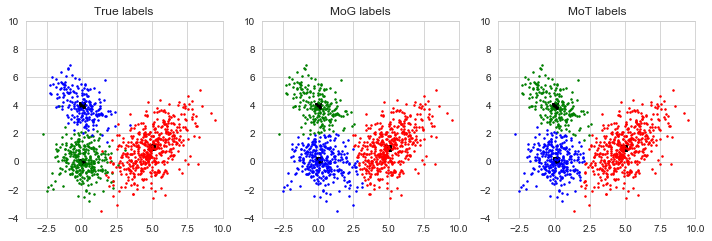

In [13]:
plt.figure(figsize=(12, 6))

ax = plt.subplot(1,3,1, aspect='equal')
plt.plot(x[ind==0,0],x[ind==0,1],'.g', markersize=3) 
plt.plot(x[ind==1,0],x[ind==1,1],'.r', markersize=3) 
plt.plot(x[ind==2,0],x[ind==2,1],'.b', markersize=3)
plt.scatter(m[:,0], m[:,1], s = 30, c = 'k', marker = 's')

plt.xlim((-4,10))
plt.ylim((-4,10))
plt.title('True labels')

ax = plt.subplot(1,3,2, aspect='equal')
plt.plot(x[ind1==0,0],x[ind1==0,1],'.g', markersize=3) 
plt.plot(x[ind1==1,0],x[ind1==1,1],'.r', markersize=3) 
plt.plot(x[ind1==2,0],x[ind1==2,1],'.b', markersize=3)
plt.scatter(m1[:,0], m1[:,1], s = 30, c = 'k', marker = 's')

plt.xlim((-4,10))
plt.ylim((-4,10))
plt.title('MoG labels')

ax = plt.subplot(1,3,3, aspect='equal')
plt.plot(x[ind2==0,0],x[ind2==0,1],'.g', markersize=3) 
plt.plot(x[ind2==1,0],x[ind2==1,1],'.r', markersize=3) 
plt.plot(x[ind2==2,0],x[ind2==2,1],'.b', markersize=3)
plt.scatter(m2[:,0], m2[:,1], s = 30, c = 'k', marker = 's')

plt.xlim((-4,10))
plt.ylim((-4,10))
plt.title('MoT labels')

## Task 3: Model complexity
A priori we do not how many neurons we recorded. Extend your algorithm with an automatic procedure to select the appropriate number of mixture components (clusters). Base your decision on the Bayesian Information Criterion:

$BIC = -2L+P \log N,$

where $L$ is the log-likelihood of the data under the best model, $P$ is the number of parameters of the model and $N$ is the number of data points. Make sure you use the right likelihood, depending on whether you fit Gaussian or t-distributions. You want to minimize the quantity. Plot the BIC as a function of mixture components. What is the optimal number of clusters on the toy dataset?

You can also use the BIC to make your algorithm robust against suboptimal solutions due to local minima. Start the algorithm multiple times and pick the best solutions. You will notice that this depends a lot on which initialization strategy you use.

*Grading: 2 pts*



In [14]:
def mog_bic(x, m, S, p):
# Compute the BIC for a fitted Mixture of Gaussian model
#   bic, LL = mog_bic(x,k) computes the the Bayesian Information 
#   Criterion value and the log-likelihood of the fitted model.
#
#   x:     N by D
#   m:     k by D
#   S:     D by D by k
#   p:     k

#   bic:   1 by 1
#   LL:    1 by 1
    N = x.shape[0]
    k = m.shape[0]
    D = x.shape[1]
    LL=0
    temp = np.zeros((N,k))
    # calculate LL, the log-likelihood of the data under the best model
    for i in range(0,N):
        for j in range(0,k):
            temp[i,j] = p[j]*sp.stats.multivariate_normal.pdf(x[i,:], m[j,:],S[:,:,j])
            
    LL = np.sum(np.log(np.sum(temp, axis=1)))
    
    # calculate BIC score
    numParameters = k + k*D + k*D*(1+D)/2
    bic = -2*LL + numParameters*np.log(N)
    
    return (bic, LL)
    

In [15]:
def mot_bic(x, m, S, p, df):
# Compute the BIC for a fitted Mixture of t-distribution model
#   bic, LL = mot_bic(x,k) computes the the Bayesian Information 
#   Criterion value and the log-likelihood of the fitted model.
#
#   x:     N by D
#   m:     k by D
#   S:     D by D by k
#   p:     k

#   bic:   1 by 1
#   LL:    1 by 1
    N = x.shape[0]
    k = m.shape[0]
    D = x.shape[1]
    LL=0
    temp = np.zeros((N,k))
    # calculate LL, the log-likelihood of the data under the best model
    for i in range(0,N):
        for j in range(0,k):
            _ ,prob = multivariate_t_pdf(x[i,:],m[j,:], S[:,:,j], df)
            temp[i,j] = p[j]*prob
            
    LL = np.sum(np.log(np.sum(temp, axis=1)))
    
    # calculate BIC score
    numParameters = k + k*D + k*D*(1+D)/2
    bic = -2*LL + numParameters*np.log(N)
    
    return (bic, LL)

Fit and compute the BIC for mixture models with different numbers of clusters (e.g., between 2 and 6).

In [17]:
K = [2, 3, 4, 5, 6]
BIC1 = np.zeros((3,len(K)))
LL1 = np.zeros((3,len(K)))
threshold=1
# run mog and BIC multiple times here
for i in range(0,len(K)):
    for j in range(0,BIC1.shape[0]):
        _, m, S, p = sorting_mixture('mog',x,threshold,K[i],None)
        BIC1[j,i],LL1[j,i] = mog_bic(x,m,S,p)

print(BIC1)

iteration:  1  --- log LLH:  -4144.849184144382  --- LLH change:  4144.849184144382
iteration:  2  --- log LLH:  -4144.296357761246  --- LLH change:  0.5528263831356526
Clustering with  2  components did converge after  2  iterations.
iteration:  1  --- log LLH:  -4144.849184144382  --- LLH change:  4144.849184144382
iteration:  2  --- log LLH:  -4144.296357761246  --- LLH change:  0.5528263831356526
Clustering with  2  components did converge after  2  iterations.
iteration:  1  --- log LLH:  -4144.849184144382  --- LLH change:  4144.849184144382
iteration:  2  --- log LLH:  -4144.296357761246  --- LLH change:  0.5528263831356526
Clustering with  2  components did converge after  2  iterations.
iteration:  1  --- log LLH:  -4063.0087494650747  --- LLH change:  4063.0087494650747
iteration:  2  --- log LLH:  -4060.3620202323705  --- LLH change:  2.646729232704274
iteration:  3  --- log LLH:  -4059.116894746314  --- LLH change:  1.2451254860566223
iteration:  4  --- log LLH:  -4058.5360

In [18]:
K = [2, 3, 4, 5, 6]
BIC2 = np.zeros((3,len(K)))
LL2 = np.zeros((3,len(K)))
df=20
threshold=1
# run mot and BIC multiple times here
for i in range(0,len(K)):
    for j in range(0,BIC2.shape[0]):
        _, m, S, p = sorting_mixture('mot',x,threshold,K[i],df)
        BIC2[j,i],LL2[j,i] = mot_bic(x,m,S,p,df)
print(BIC2)

iteration:  1  --- log LLH:  -4151.853681079625  --- LLH change:  4151.853681079625
iteration:  2  --- log LLH:  -4151.213432773186  --- LLH change:  0.6402483064393891
Clustering with  2  components did converge after  2  iterations.
iteration:  1  --- log LLH:  -4151.853681079625  --- LLH change:  4151.853681079625
iteration:  2  --- log LLH:  -4151.213432773186  --- LLH change:  0.6402483064393891
Clustering with  2  components did converge after  2  iterations.
iteration:  1  --- log LLH:  -4151.853681079625  --- LLH change:  4151.853681079625
iteration:  2  --- log LLH:  -4151.213432773186  --- LLH change:  0.6402483064393891
Clustering with  2  components did converge after  2  iterations.
iteration:  1  --- log LLH:  -4064.0515787594322  --- LLH change:  4064.0515787594322
iteration:  2  --- log LLH:  -4061.4749018931093  --- LLH change:  2.5766768663229414
iteration:  3  --- log LLH:  -4060.318286505566  --- LLH change:  1.1566153875432974
iteration:  4  --- log LLH:  -4059.779

Text(0.5, 1.0, 'MoT')

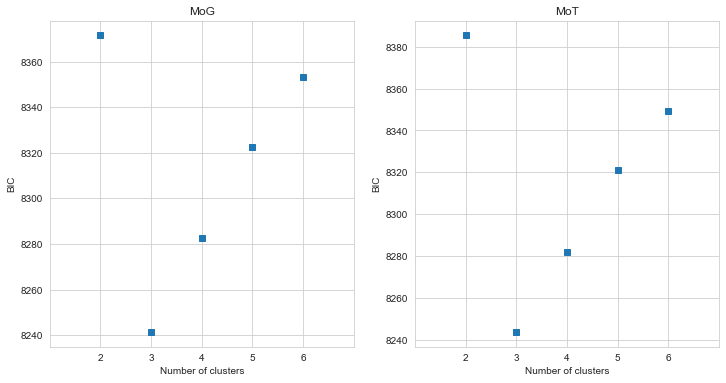

In [25]:
plt.figure(figsize=(12, 6))

ax = plt.subplot(1,2,1)
plt.plot(K,np.min(BIC1,axis=0),'s')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.xticks(K)
plt.xlim((1,7))
plt.title('MoG')

ax = plt.subplot(1,2,2)
plt.plot(K,np.min(BIC2,axis=0),'s')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.xticks(K)
plt.xlim((1,7))
plt.title('MoT')

The optimum cluster number on toy dataset is 3.

## Task 4: Spike sorting using Mixture of Gaussian 
Run the full algorithm on your set of extracted features (including model complexity selection). Plot the BIC as a function of the number of mixture components on the real data. For the best model, make scatter plots of the first PCs on all four channels (6 plots). Color-code each data point according to its class label in the model with the optimal number of clusters. In addition, indicate the position (mean) of the clusters in your plot. If you implemented t-distributions above, compare Gaussian and t-distribution based solutions.

*Grading: 3 pts*


In [28]:
b.shape

(20453, 12)

In [19]:
K = np.arange(2,14)
BIC1 = np.zeros(len(K))
LL1 = np.zeros(len(K))
threshold = 10
for j in np.arange(0,len(K)):
    _, m, S, p = sorting_mixture('mog',b,threshold,K[j],None)
    BIC1[j],LL1[j] = mog_bic(b,m,S,p)
  

iteration:  1  --- log LLH:  -1437008.698104471  --- LLH change:  1437008.698104471
iteration:  2  --- log LLH:  -1436501.707666891  --- LLH change:  506.9904375800397
iteration:  3  --- log LLH:  -1436370.9411058363  --- LLH change:  130.76656105462462
iteration:  4  --- log LLH:  -1436337.1873516045  --- LLH change:  33.75375423184596
iteration:  5  --- log LLH:  -1436329.1132377984  --- LLH change:  8.074113806011155
Clustering with  2  components did converge after  5  iterations.
iteration:  1  --- log LLH:  -1427578.441314794  --- LLH change:  1427578.441314794
iteration:  2  --- log LLH:  -1425883.3393018579  --- LLH change:  1695.1020129360259
iteration:  3  --- log LLH:  -1424462.9679025833  --- LLH change:  1420.3713992745616
iteration:  4  --- log LLH:  -1424374.956836427  --- LLH change:  88.01106615620665
iteration:  5  --- log LLH:  -1424365.8109116396  --- LLH change:  9.145924787502736
Clustering with  3  components did converge after  5  iterations.
iteration:  1  --- 

iteration:  14  --- log LLH:  -1415529.2293670243  --- LLH change:  41.5840784360189
iteration:  15  --- log LLH:  -1415462.9098732357  --- LLH change:  66.31949378852732
iteration:  16  --- log LLH:  -1415373.3939118397  --- LLH change:  89.51596139604226
iteration:  17  --- log LLH:  -1415269.8166893916  --- LLH change:  103.57722244807519
iteration:  18  --- log LLH:  -1415147.4185227372  --- LLH change:  122.39816665439866
iteration:  19  --- log LLH:  -1414992.0331775052  --- LLH change:  155.3853452319745
iteration:  20  --- log LLH:  -1414834.5776957993  --- LLH change:  157.4554817059543
iteration:  21  --- log LLH:  -1414698.765029938  --- LLH change:  135.8126658613328
iteration:  22  --- log LLH:  -1414582.471659515  --- LLH change:  116.29337042290717
iteration:  23  --- log LLH:  -1414496.3106952535  --- LLH change:  86.16096426150762
iteration:  24  --- log LLH:  -1414437.3243509033  --- LLH change:  58.986344350269064
iteration:  25  --- log LLH:  -1414386.4465158351  --

iteration:  11  --- log LLH:  -1410991.819204946  --- LLH change:  121.05019879364409
iteration:  12  --- log LLH:  -1410912.7881810812  --- LLH change:  79.03102386486717
iteration:  13  --- log LLH:  -1410855.8864211773  --- LLH change:  56.901759903877974
iteration:  14  --- log LLH:  -1410810.3768056293  --- LLH change:  45.509615547955036
iteration:  15  --- log LLH:  -1410770.5019851164  --- LLH change:  39.87482051295228
iteration:  16  --- log LLH:  -1410734.2297686026  --- LLH change:  36.27221651375294
iteration:  17  --- log LLH:  -1410701.192213784  --- LLH change:  33.0375548186712
iteration:  18  --- log LLH:  -1410669.1905775694  --- LLH change:  32.00163621455431
iteration:  19  --- log LLH:  -1410636.4234459277  --- LLH change:  32.76713164173998
iteration:  20  --- log LLH:  -1410614.133641058  --- LLH change:  22.28980486956425
iteration:  21  --- log LLH:  -1410597.5951720586  --- LLH change:  16.538468999555334
iteration:  22  --- log LLH:  -1410584.378830473  --- 

iteration:  13  --- log LLH:  -1409553.155164509  --- LLH change:  59.62718309625052
iteration:  14  --- log LLH:  -1409494.0542976744  --- LLH change:  59.10086683463305
iteration:  15  --- log LLH:  -1409432.239152814  --- LLH change:  61.81514486041851
iteration:  16  --- log LLH:  -1409364.4430504167  --- LLH change:  67.79610239737667
iteration:  17  --- log LLH:  -1409287.6605018228  --- LLH change:  76.78254859382287
iteration:  18  --- log LLH:  -1409202.4066149069  --- LLH change:  85.25388691597618
iteration:  19  --- log LLH:  -1409115.891570519  --- LLH change:  86.51504438789561
iteration:  20  --- log LLH:  -1409039.937165678  --- LLH change:  75.95440484094433
iteration:  21  --- log LLH:  -1408984.8620159335  --- LLH change:  55.07514974451624
iteration:  22  --- log LLH:  -1408946.2162825188  --- LLH change:  38.64573341468349
iteration:  23  --- log LLH:  -1408914.7921067406  --- LLH change:  31.424175778171048
iteration:  24  --- log LLH:  -1408886.8566182738  --- LL

In [ ]:
K = np.arange(2,14)
BIC2 = np.zeros(len(K))
LL2 = np.zeros(len(K))
df=20
threshold = 10
for j in np.arange(0,len(K)):
    ind, m, S, p = sorting_mixture('mot',b,threshold,K[j],df)
    BIC2[j],LL2[j] = mot_bic(b,m,S,p,df)
    if j==0:
        old_score = BIC2[j]
    else:
        new_score = BIC2[j]
        if new_score<old_score:
            record_ind = ind
            record_m = m
        old_score = new_score

# record data for plotting
m2 = record_m
ind2 = record_ind
  

Plot BIC

Text(0.5, 1.0, 'MoG')

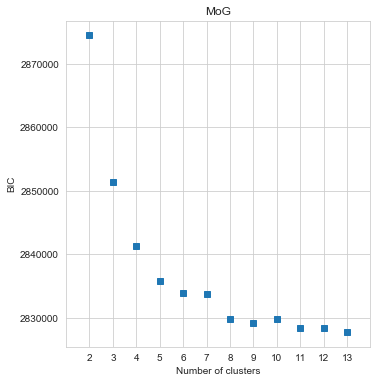

In [20]:
plt.figure(figsize=(12, 6))
K = np.arange(2,14)
ax = plt.subplot(1,2,1)
plt.plot(K,BIC1,'s')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.xticks(K)
plt.xlim((1,14))
plt.title('MoG')

ax = plt.subplot(1,2,2)
plt.plot(K,BIC2,'s')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.xticks(K)
plt.xlim((7,14))
plt.title('MoT')

Refit model with lowest BIC and plot data points

In [21]:
def plot_result(data,centers,labels,title):
    b=data
    m=centers
    ind = labels
    k = m.shape[0] # number of clusters
    
    NUM_COLORS = k

    cm = plt.get_cmap('gist_rainbow')
    colors = np.zeros((NUM_COLORS,4))
    for i in range(NUM_COLORS):
        colors[i,:] = cm(i/NUM_COLORS)

    plt.figure(figsize=(15,9))
    idx_plot=1
    idx_PC1 = [0, 3, 6, 9]
    for i in range(0,4):
        for j in range(i+1,4): 
            plt.subplot(2,3,idx_plot,aspect='equal')

            for idx_cluster in range(0,k):
                plt.plot(b[ind==idx_cluster,idx_PC1[i]],b[ind==idx_cluster,idx_PC1[j]],'.',markersize=.5,c=colors[idx_cluster,:],alpha=0.3) 
                plt.plot(m[idx_cluster,idx_PC1[i]],m[idx_cluster,idx_PC1[j]],'*k',markersize=8) 
            plt.xlabel('Ch ' + str(i+1))
            plt.ylabel('Ch ' + str(j+1))
            plt.xlim((-1500,1500))
            plt.ylim((-1500,1500))
            plt.title(title)
            ax = plt.gca()
            ax.set_xticks([])
            ax.set_yticks([])
            idx_plot = idx_plot + 1
        
    plt.show()

iteration:  1  --- log LLH:  -1415289.572217591  --- LLH change:  1415289.572217591
iteration:  2  --- log LLH:  -1413310.0103723886  --- LLH change:  1979.5618452024646
iteration:  3  --- log LLH:  -1412109.7040530317  --- LLH change:  1200.306319356896
iteration:  4  --- log LLH:  -1411305.0663087391  --- LLH change:  804.6377442926168
iteration:  5  --- log LLH:  -1410706.9194493499  --- LLH change:  598.1468593892641
iteration:  6  --- log LLH:  -1410229.1082767705  --- LLH change:  477.81117257941514
iteration:  7  --- log LLH:  -1409903.0224253987  --- LLH change:  326.08585137175396
iteration:  8  --- log LLH:  -1409699.7377457183  --- LLH change:  203.2846796803642
iteration:  9  --- log LLH:  -1409565.2105937656  --- LLH change:  134.5271519527305
iteration:  10  --- log LLH:  -1409466.180607076  --- LLH change:  99.0299866895657
iteration:  11  --- log LLH:  -1409385.3825470079  --- LLH change:  80.79806006816216
iteration:  12  --- log LLH:  -1409314.5465339825  --- LLH chan

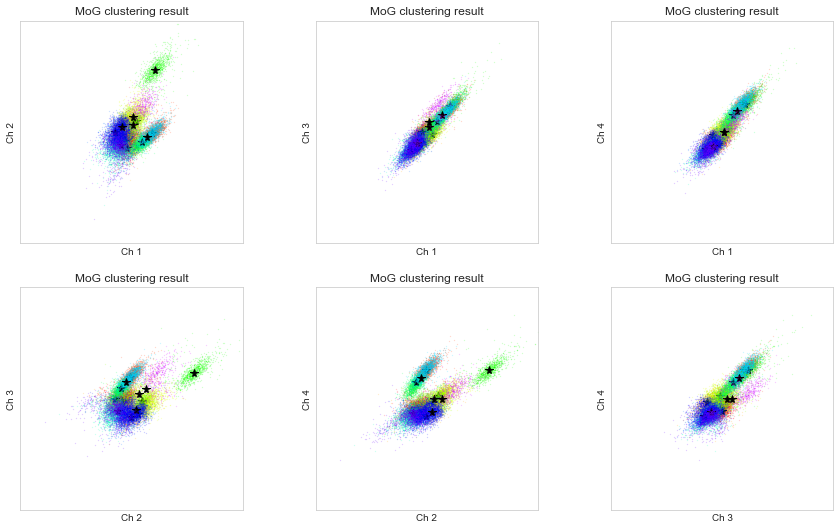

In [24]:
k1 = K[np.argmin(BIC1)]
threshold=10
ind1, m1, S1, p1 = sorting_mixture('mog',b,threshold,k1,None)
print(k1)
plot_result(b,m1,ind1,'MoG clustering result')



In [ ]:
k2 = K[np.argmin(BIC2)]
df=20
threshold = 10
ind2, m2, S2, p2 = sorting_mixture('mot',b,threshold,k2,df)
print(k2)
plot_result(b,m2,ind2,'MoT clustering result')

t-distribution solutions converge faster than Gaussian based solutions. When the optimum clusters numbers are the same, the clusters for t-distribution based solutions have longer tails.

In [ ]:
np.save('data//nda_ex_2_means',m2)
np.save('data//nda_ex_2_covs',S2)
np.save('data//nda_ex_2_pis',p2)
a = ind2
np.save('data//nda_ex_2_labels',a)

## Optional (!) Task 5: Advanced methods
Try implementing a basic version of one of the more advanced algorithms discussed in the lecture, such as:

- Mixture of drifting t-distributions (follow https://github.com/aecker/moksm/blob/master/MoT_Kalman.pdf)
- Template matching approach using binary pursuit (follow https://github.com/aecker/bpsort)



*Grading: 5 extra pts*